## load packages

In [35]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sb

import os
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB,BernoulliNB

import re
import emoji

from collections import Counter
from sklearn.datasets import make_classification

from imblearn.under_sampling import RandomUnderSampler
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from nltk import FreqDist
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, CuDNNLSTM, concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D, Dropout, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shaoxing/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/shaoxing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Reading Dataset

In [36]:
## directory of dataset
root="/Users/shaoxing/Desktop/dataset/"

In [37]:
## read the train dataset
train_dataset=pd.read_csv(root+'offenseval-training-v1.tsv' , sep='\t')


In [38]:
## read the test_dataset
test_data = pd.read_csv(root+'testset-levelb.tsv' , sep='\t') 

test_labels=pd.read_csv(root+'labels-levelb.csv' , sep='\t') 

test_labels=np.array(test_labels)

test_labels=np.insert(test_labels,0,['15923,TIN'])
labels=[]
for item in test_labels:
    labels.append(item.split(",")[1])


labels=pd.DataFrame(labels, columns=["subtask_b"])

test_dataset = pd.concat([test_data, labels], axis=1)
#test_dataset

## Dataset Preprocessing

In [39]:
def emojiProcessing (text):
    
    text = emoji.demojize(text)
     
    text = re.compile("([\U0001f3fb-\U0001f3ff])").sub(r'',text) 
    text = re.compile("([\U00010000-\U0010ffff])").sub(r'',text) 
    text = re.compile("(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff])").sub(r'',text)

     
    text = re.compile("([\U00010000-\U0010ffff])").sub(r' \1 ',text) 
    return text

In [40]:
## define function to perform tweets cleaning
def tweetPreprocessing (text):
    
    
    text = re.compile(r'@USER').sub(r'<user>',text)# Replace @USER by <user>

    
    text = re.compile(r'URL').sub(r'<url>',text)# Replace URL by <url>

    
    text = re.compile(r'[0-9]+').sub(r' ',text)# Remove numbers :

    
    text = re.compile(r'([\xa0_\{\}\[\]¬•$,:;/@#|\^*%().~`”"“-])').sub(r' ',text) # Remove some special characters

    
    text = re.compile(r'([$&+,:;=?@#|\'.^*()%!"’“-])').sub(r' \1 ',text)# Space the special characters with white spaces

    
    replace_dict = {r'&' : 'and' , r'&amp;' : 'and' , 
                    r'\+' : 'plus'} # Replace some special characters : 
    for cha in replace_dict:
        text = re.compile(str(cha)).sub(str(replace_dict[cha]),text)

    
    text = emojiProcessing(text)# Handle Emoji

    
    text = re.compile(r'(.)\1{3,}').sub(r'\1\1',text)# Word delengthening : 

    
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)        
    
   
    text = text.split(' ')

    
    text = [text[i] for i in range(len(text)) if text[i] != ' ']# Remove white spaces tokens

    
    text = [text[i] for i in range(len(text)) if text[i] != '']# Remove empty tokens

   
    text = [text[i] for i in range(len(text)) if text[i] != text[i-1]] # Remove repetition in tokens (!!! => !)

    #  Handle the ALL CAPS Tweets 

    caps_r = np.mean([text[i].isupper() for i in range(len(text))])
    if caps_r > 0.6 : 
        text.append('<allcaps>')

   
    text = [text[i].lower() for i in range(len(text))]
    
    return " ".join(str(x) for x in text)

In [41]:
## preprocessing the train dataset
train_dataset['subtask_b'].replace({'UNT':0, 'TIN': 1}, inplace= True)
train_dataset["preprocessed_tweet"] = train_dataset["tweet"].apply(tweetPreprocessing)
train_dataset.head()

,id,tweet,subtask_a,subtask_b,subtask_c,preprocessed_tweet
0,86426,@USER She should ask a few native Americans wh...,OFF,0.0,NaN,<user> she should ask a few native americans w...
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1.0,IND,<user> go home you re drunk ! <user> maga trum...
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,amazon is investigating chinese employees who ...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,0.0,NaN,<user> someone should ' ve taken this piece of...
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,<user> obama wanted liberals and amp illegals ...


In [42]:
## preprocessing the test dataset
test_dataset['subtask_b'].replace({'UNT':0, 'TIN': 1}, inplace= True)
test_dataset["preprocessed_tweet"] = test_dataset["tweet"].apply(tweetPreprocessing)
test_dataset.head()

,id,tweet,subtask_b,preprocessed_tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,1,who isq wheres the server dump nike declasfisa...
1,60133,#NoPasaran: Unity demo to oppose the far-right...,1,no pasaran unity demo to oppose the far right ...
2,83681,. . . What the fuck did he do this time?,1,what the fuck did he do this time ?
3,65507,@USER Do you get the feeling he is kissing @US...,1,<user> do you get the feeling he is kissing <u...
4,12588,@USER Nigga ware da hits at,0,<user> nigga ware da hits at


## Extract Features

In [43]:
Tweets = train_dataset["preprocessed_tweet"].values
labels = train_dataset["subtask_b"].values

In [44]:
train_Tweets=Tweets
train_labels=labels

test_Tweets=test_dataset["preprocessed_tweet"].values
test_labels=test_dataset["subtask_b"].values

## Features Extraction: TF-IDF

In [45]:
def tf_idf(Tweets, train_Tweets, test_Tweets):
    
    tfidfVectorizer = TfidfVectorizer()
    tfidfVectorizer.fit(Tweets)

    train_text_features_tf = tfidfVectorizer.transform(train_Tweets)
    test_text_features_tf = tfidfVectorizer.transform(test_Tweets)
    
    return train_text_features_tf, test_text_features_tf

## Features Extraction: CountVectorizer

In [46]:
def count(Tweets, train_Tweets, test_Tweets):
    
    countVectorizer = CountVectorizer()
    countVectorizer.fit(Tweets)

    train_text_features_cv = countVectorizer.transform(train_Tweets)
    test_text_features_cv = countVectorizer.transform(test_Tweets)
    
    return train_text_features_cv, test_text_features_cv

## Sampling: Undersampling 

In [47]:
def undersampling(train_text_features_tf, train_labels):
    randomUnderSampler = RandomUnderSampler(random_state=0)
    Tweets_resampled, labels_resampled = randomUnderSampler.fit_resample(train_text_features_tf, train_labels)
    return Tweets_resampled, labels_resampled

## Sampling: Oversampling

In [48]:
def oversampling(train_text_features_tf, train_labels):
    from imblearn.over_sampling import SMOTE
    smote = SMOTE('minority')
    Tweets_oversampled, labels_oversampled = smote.fit_resample(train_text_features_tf, train_labels)
    return Tweets_oversampled, labels_oversampled

## Plotting Confusion Matrix

In [49]:
def confusionMatrix(labels_test, labels_pred):
    
  
    mat = confusion_matrix(labels_test, labels_pred)
    cm = pd.DataFrame(mat)
    TP = cm.iloc[1,1] # True Positive
    TN = cm.iloc[0,0] # True Negative
    FP = cm.iloc[0,1] # False Positive
    FN = cm.iloc[1,0] # False Negative

    print('Sensitivity: {:.2%}'.format(TP/(FN+TP)))
    print('Specificity: {:.2%}'.format(TN/(FP+TN)))
  
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
    plt.title('A confusion matrix showing the frequency of misclassifications by classifier')
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    plt.show()

## Model Processing Function

In [50]:
def modelBuild(model, Tweets, train_Tweets, train_labels, test_Tweets, test_labels, tfidf = False, cv = False, undersampled = False, oversample = False):
    
    if tfidf:
        print('Feature Extraction using TFIFD')
        train_text_features, test_text_features = tf_idf(Tweets, train_Tweets, test_Tweets)
    
    if cv:
        print('Feature Extraction using CV')
        train_text_features, test_text_features = count(Tweets, train_Tweets, test_Tweets)

    if undersampled:
        print('Undersampling the dataset')
        train_text_features, train_labels = undersampling(train_text_features, train_labels)

    if oversample:
        print('Oversampling the dataset')
        train_text_features, train_labels = oversampling(train_text_features, train_labels)
        
    model.fit(train_text_features, train_labels)

    
    predictions = model.predict(test_text_features)

    # Use accuracy_score function to get the accuracy
    print("Accuracy Score -> ",accuracy_score(predictions, test_labels)*100)

    print('F1Score', f1_score(predictions, test_labels, average="macro"))
    print('Precision', precision_score(predictions, test_labels, average="macro"))
    print('Recall', recall_score(predictions, test_labels, average="macro"))

    confusionMatrix(test_labels, predictions)

## SVM : Undersampling and Count

Feature Extraction using CV
Undersampling the dataset
Accuracy Score ->  53.333333333333336
F1Score 0.4681861348528015
Precision 0.6562336984872196
Recall 0.5627487953069349
Sensitivity: 49.77%
Specificity: 81.48%


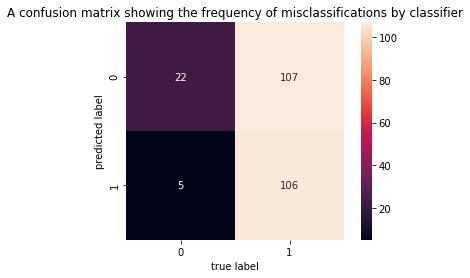

In [60]:
modelBuild(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = False, cv = True, undersampled = True, oversample = False)

## SVM: Count and Original data

Feature Extraction using CV
Accuracy Score ->  84.16666666666667
F1Score 0.603547209181012
Precision 0.603547209181012
Recall 0.603547209181012
Sensitivity: 91.08%
Specificity: 29.63%


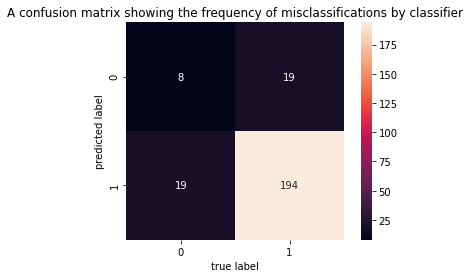

In [61]:
modelBuild(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = False, cv = True, undersampled = False, oversample = False)

## SVM: TFIDF and Original dataset

Feature Extraction using TFIFD
Accuracy Score ->  88.75
F1Score 0.47019867549668876
Precision 0.5
Recall 0.44375
Sensitivity: 100.00%
Specificity: 0.00%


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


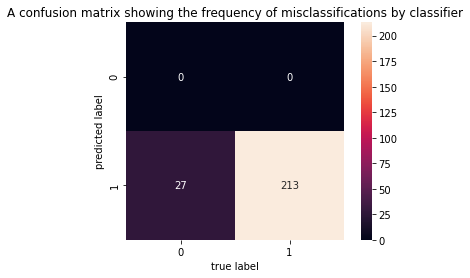

In [62]:
modelBuild(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = True, cv = False, undersampled = False, oversample = False)

## SVM:Oversampling and TFIDF

Feature Extraction using TFIFD
Oversampling the dataset


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


Accuracy Score ->  83.75
F1Score 0.599572192513369
Precision 0.6011997913406364
Recall 0.5980458221024259
Sensitivity: 90.61%
Specificity: 29.63%


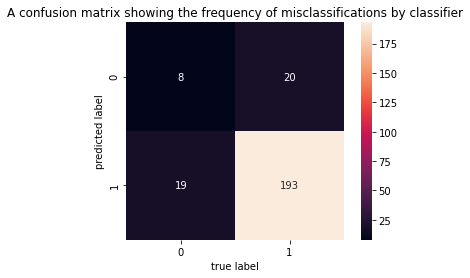

In [63]:
modelBuild(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = True, cv = False, undersampled = False, oversample = True)

## SVM:Oversampling and Count

Feature Extraction using CV
Oversampling the dataset


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


Accuracy Score ->  82.5
F1Score 0.6402055968018275
Precision 0.6750130412102243
Recall 0.6233607059688687
Sensitivity: 86.85%
Specificity: 48.15%


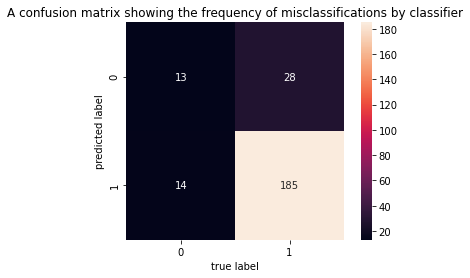

In [64]:
modelBuild(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = False, cv = True, undersampled = False, oversample = True)

## Random Forest: Count and Oversampling

Feature Extraction using CV
Oversampling the dataset


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


Accuracy Score ->  70.83333333333334
F1Score 0.5578947368421052
Precision 0.6416275430359937
Recall 0.5668115823148224
Sensitivity: 72.77%
Specificity: 55.56%


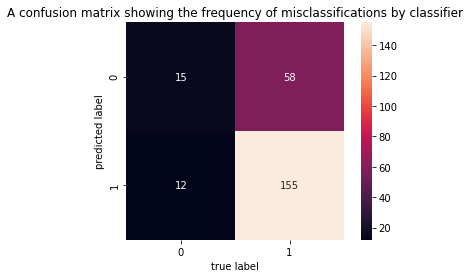

In [66]:
modelBuild(RandomForestClassifier(n_estimators=100, max_depth=4,random_state=0), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = False, cv = True, undersampled = False, oversample = True)


## Random Forest: Count and Undersampling

Feature Extraction using CV
Undersampling the dataset
Accuracy Score ->  59.166666666666664
F1Score 0.5016526824307145
Precision 0.656755346896192
Recall 0.5629583071443537
Sensitivity: 57.28%
Specificity: 74.07%


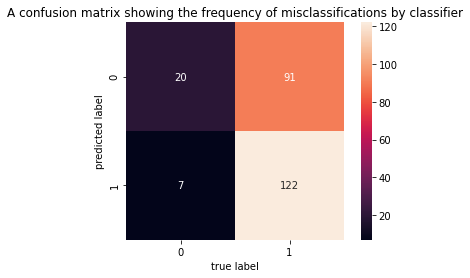

In [67]:
modelBuild(RandomForestClassifier(n_estimators=100, max_depth=4,random_state=0), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = False, cv = True, undersampled = True, oversample = False)


## Random Forest: Count and Original Data

Feature Extraction using CV
Accuracy Score ->  88.75
F1Score 0.47019867549668876
Precision 0.5
Recall 0.44375
Sensitivity: 100.00%
Specificity: 0.00%


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


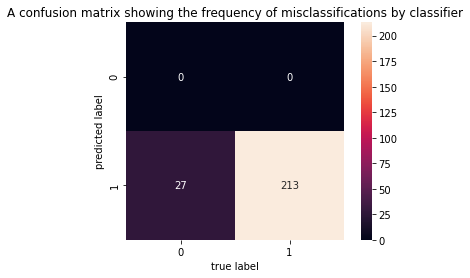

In [68]:
modelBuild(RandomForestClassifier(n_estimators=100, max_depth=4,random_state=0), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = False, cv = True, undersampled = False, oversample = False)


## Random Forest: TFIDF and Original Data

Feature Extraction using TFIFD
Accuracy Score ->  88.75
F1Score 0.47019867549668876
Precision 0.5
Recall 0.44375
Sensitivity: 100.00%
Specificity: 0.00%


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


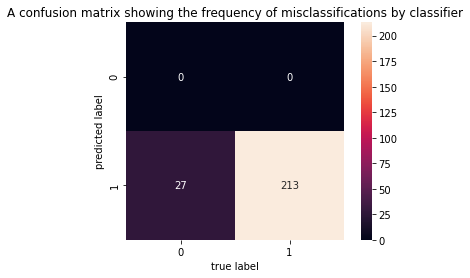

In [69]:
modelBuild(RandomForestClassifier(n_estimators=100, max_depth=4,random_state=0), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = True, cv = False, undersampled = False, oversample = False)


## Random Forest: TFIDF and Undersampling

Feature Extraction using TFIFD
Undersampling the dataset
Accuracy Score ->  66.66666666666666
F1Score 0.5452823039029936
Precision 0.6666666666666666
Recall 0.5713222710023067
Sensitivity: 66.67%
Specificity: 66.67%


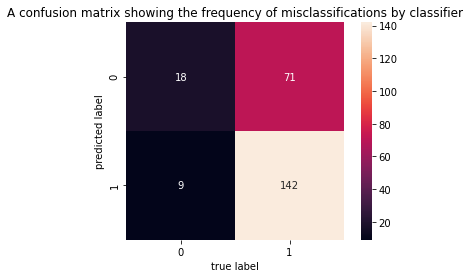

In [70]:
modelBuild(RandomForestClassifier(n_estimators=100, max_depth=4,random_state=0), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = True, cv = False, undersampled = True, oversample = False)


## Random Forest: TFIDF and Oversampling

Feature Extraction using TFIFD
Oversampling the dataset


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


Accuracy Score ->  79.58333333333333
F1Score 0.5950273769757911
Precision 0.6262389149713093
Recall 0.5841836734693877
Sensitivity: 84.51%
Specificity: 40.74%


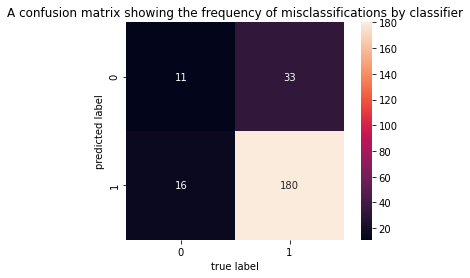

In [71]:
modelBuild(RandomForestClassifier(n_estimators=100, max_depth=4,random_state=0), Tweets, train_Tweets, train_labels,
      test_Tweets, test_labels, tfidf = True, cv = False, undersampled = False, oversample = True)


## Deep learning

In [80]:
## split dataset into training set and validation set
from sklearn.model_selection import train_test_split
training_Tweets, val_Tweets, training_labels, val_labels = train_test_split(train_Tweets, train_labels, stratify=train_labels, test_size=0.2)



## Tokenize tweets

In [83]:
max_features = 50000 
maxlen = 100

In [85]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(training_Tweets))
training_Tweets = tokenizer.texts_to_sequences(training_Tweets)
val_Tweets = tokenizer.texts_to_sequences(val_Tweets)
test_Tweets = tokenizer.texts_to_sequences(test_Tweets)

## Padding Tweets

In [88]:
training_Tweets = pad_sequences(training_Tweets, maxlen=maxlen)
test_Tweets = pad_sequences(test_Tweets, maxlen=maxlen)
val_Tweets = pad_sequences(val_Tweets, maxlen=maxlen)

In [89]:
S_DROPOUT = 0.4
DROPOUT = 0.1

In [90]:
def plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()    

In [91]:
embed_size = 100
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          5000000   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         84480     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0     

Epoch 1/10
7/7 [==============================] - 3s 456ms/step - loss: 0.3188 - accuracy: 0.8810 - val_loss: 0.3411 - val_accuracy: 0.8807
Epoch 2/10
7/7 [==============================] - 3s 449ms/step - loss: 0.2782 - accuracy: 0.8810 - val_loss: 0.3591 - val_accuracy: 0.8807
Epoch 3/10
7/7 [==============================] - 3s 450ms/step - loss: 0.2206 - accuracy: 0.8810 - val_loss: 0.4240 - val_accuracy: 0.8807
Epoch 4/10
7/7 [==============================] - 3s 461ms/step - loss: 0.1775 - accuracy: 0.9193 - val_loss: 0.4535 - val_accuracy: 0.8091
Epoch 5/10
7/7 [==============================] - 3s 448ms/step - loss: 0.1707 - accuracy: 0.9261 - val_loss: 0.4877 - val_accuracy: 0.7989
Epoch 6/10
7/7 [==============================] - 3s 452ms/step - loss: 0.1575 - accuracy: 0.9384 - val_loss: 0.5202 - val_accuracy: 0.8159
Epoch 7/10
7/7 [==============================] - 3s 449ms/step - loss: 0.1478 - accuracy: 0.9460 - val_loss: 0.5263 - val_accuracy: 0.8080
Epoch 8/10
7/7 [====

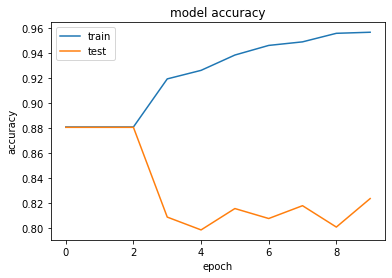

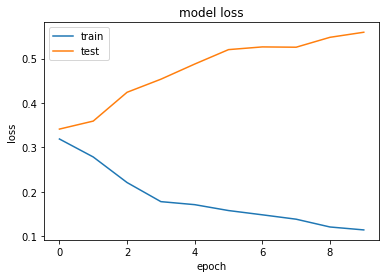

Test Accuracy: 83.749998


In [93]:
#Tweets_resampled, labels_resampled = training_Tweets, training_labels

history = model.fit(training_Tweets, training_labels, batch_size=512, epochs=10, validation_data=(val_Tweets, val_labels))
plot(history)

loss, accuracy = model.evaluate(test_Tweets, test_labels, verbose=0)
print('Test Accuracy: %f' % (accuracy*100))


In [95]:
pred_val_labels = model.predict([val_Tweets], batch_size=1024, verbose=1)

1/1 [==============================] - 1s 787ms/step


In [97]:
from sklearn import metrics
thresholds = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    res = metrics.f1_score(val_labels, (pred_val_labels > thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))
    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh)

F1 score at threshold 0.1 is 0.9365558912386707
F1 score at threshold 0.11 is 0.9365558912386707
F1 score at threshold 0.12 is 0.9365558912386707
F1 score at threshold 0.13 is 0.9365558912386707
F1 score at threshold 0.14 is 0.9365558912386707
F1 score at threshold 0.15 is 0.9365558912386707
F1 score at threshold 0.16 is 0.9365558912386707
F1 score at threshold 0.17 is 0.9365558912386707
F1 score at threshold 0.18 is 0.9365558912386707
F1 score at threshold 0.19 is 0.9365558912386707
F1 score at threshold 0.2 is 0.9365558912386707
F1 score at threshold 0.21 is 0.9365558912386707
F1 score at threshold 0.22 is 0.9365558912386707
F1 score at threshold 0.23 is 0.9365558912386707
F1 score at threshold 0.24 is 0.9365558912386707
F1 score at threshold 0.25 is 0.9365558912386707
F1 score at threshold 0.26 is 0.9365558912386707
F1 score at threshold 0.27 is 0.9365558912386707
F1 score at threshold 0.28 is 0.935912938331318
F1 score at threshold 0.29 is 0.934065934065934
F1 score at threshold 0.

In [98]:
pred_test_labels = model.predict([test_Tweets], batch_size=1024, verbose=1)
pred_test_labels =  (pred_test_labels > best_thresh).astype(int)

unique, counts = np.unique(pred_test_labels, return_counts=True)
print(np.asarray((unique, counts)).T)

1/1 [==============================] - 0s 123ms/step
[[  1 240]]


Sensitivity: 100.00%
Specificity: 0.00%


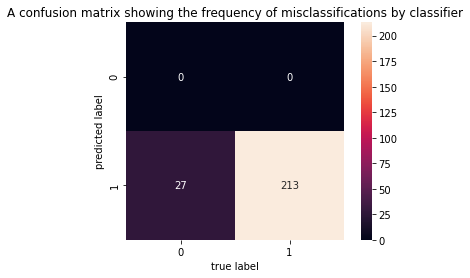

In [99]:
confusionMatrix(test_labels, pred_test_labels)

In [100]:
print(f1_score(pred_test_labels, test_labels, average="macro"))
print(precision_score(pred_test_labels, test_labels, average="macro"))
print(recall_score(pred_test_labels, test_labels, average="macro"))

0.47019867549668876
0.5
0.44375


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##  GloVe Embeddings

In [102]:
from numpy import asarray
embed_size = 200

embeddings_index = dict()
root="/Users/shaoxing/Desktop/dataset/"
f = open(root+'glove.twitter.27B.200d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [103]:
from numpy import zeros


embedding_matrix = zeros((max_features, embed_size))
for word, i in tokenizer.word_index.items():
    
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        embedding_matrix[i] = embedding_vector

In [104]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 200)          10000000  
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 128)         135680    
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0   

Epoch 1/10
7/7 [==============================] - 7s 709ms/step - loss: 0.7066 - accuracy: 0.5199 - val_loss: 0.5800 - val_accuracy: 0.8807
Epoch 2/10
7/7 [==============================] - 4s 608ms/step - loss: 0.4986 - accuracy: 0.8810 - val_loss: 0.3959 - val_accuracy: 0.8807
Epoch 3/10
7/7 [==============================] - 4s 609ms/step - loss: 0.3744 - accuracy: 0.8810 - val_loss: 0.3525 - val_accuracy: 0.8807
Epoch 4/10
7/7 [==============================] - 4s 638ms/step - loss: 0.3661 - accuracy: 0.8810 - val_loss: 0.3598 - val_accuracy: 0.8807
Epoch 5/10
7/7 [==============================] - 4s 645ms/step - loss: 0.3646 - accuracy: 0.8810 - val_loss: 0.3545 - val_accuracy: 0.8807
Epoch 6/10
7/7 [==============================] - 4s 608ms/step - loss: 0.3586 - accuracy: 0.8810 - val_loss: 0.3483 - val_accuracy: 0.8807
Epoch 7/10
7/7 [==============================] - 4s 600ms/step - loss: 0.3537 - accuracy: 0.8810 - val_loss: 0.3466 - val_accuracy: 0.8807
Epoch 8/10
7/7 [====

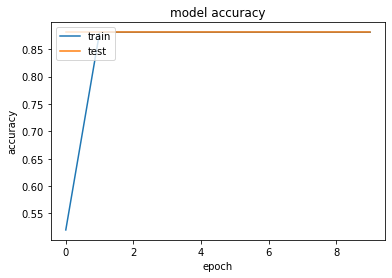

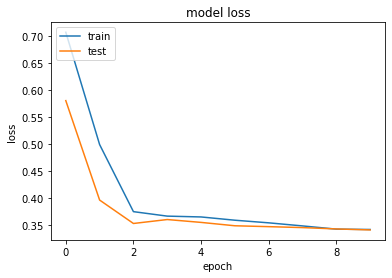

Test Accuracy: 88.749999


In [106]:
history = model.fit(training_Tweets, training_labels, batch_size=512, epochs=10, validation_data=(val_Tweets, val_labels))
plot(history)

loss, accuracy = model.evaluate(test_Tweets, test_labels, verbose=0)
print('Test Accuracy: %f' % (accuracy*100))

In [107]:
pred_val_labels = model.predict([val_Tweets], batch_size=1024, verbose=1)


thresholds = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    res = metrics.f1_score(val_labels, (pred_val_labels > thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))
    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh)

1/1 [==============================] - 1s 875ms/step
F1 score at threshold 0.1 is 0.9365558912386707
F1 score at threshold 0.11 is 0.9365558912386707
F1 score at threshold 0.12 is 0.9365558912386707
F1 score at threshold 0.13 is 0.9365558912386707
F1 score at threshold 0.14 is 0.9365558912386707
F1 score at threshold 0.15 is 0.9365558912386707
F1 score at threshold 0.16 is 0.9365558912386707
F1 score at threshold 0.17 is 0.9365558912386707
F1 score at threshold 0.18 is 0.9365558912386707
F1 score at threshold 0.19 is 0.9365558912386707
F1 score at threshold 0.2 is 0.9365558912386707
F1 score at threshold 0.21 is 0.9365558912386707
F1 score at threshold 0.22 is 0.9365558912386707
F1 score at threshold 0.23 is 0.9365558912386707
F1 score at threshold 0.24 is 0.9365558912386707
F1 score at threshold 0.25 is 0.9365558912386707
F1 score at threshold 0.26 is 0.9365558912386707
F1 score at threshold 0.27 is 0.9365558912386707
F1 score at threshold 0.28 is 0.9365558912386707
F1 score at thresh

In [108]:
pred_test_labels = model.predict([test_Tweets], batch_size=1024, verbose=1)
pred_test_labels = (pred_test_labels > best_thresh).astype(int)

unique, counts = np.unique(pred_test_labels, return_counts=True)
print(np.asarray((unique, counts)).T)

1/1 [==============================] - 0s 117ms/step
[[  1 240]]


Sensitivity: 100.00%
Specificity: 0.00%


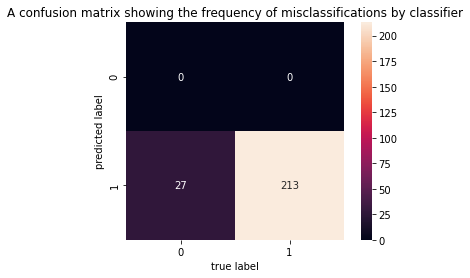

In [109]:
confusionMatrix(test_labels, pred_test_labels)

In [110]:
print(f1_score(pred_test_labels, test_labels, average="macro"))
print(precision_score(pred_test_labels, test_labels, average="macro"))
print(recall_score(pred_test_labels, test_labels, average="macro"))

0.47019867549668876
0.5
0.44375


/Users/shaoxing/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
testdf['predicted target - GloVe'] = pred_test_labels
testdf.head()

,tweet,subtask_b,predicted target,predicted target - GloVe
0,who isq wheres the server dump nike declasfisa...,1,1,1
1,no pasaran unity demo to oppose the far right ...,1,1,1
2,what the fuck did he do this time ?,1,1,1
3,<user> do you get the feeling he is kissing <u...,1,1,1
4,<user> nigga ware da hits at,0,1,1
